## Mask Predection

In [ ]:
!pip install scikit-image

In [ ]:
import cv2
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import numpy as np
import imutils
from google.colab.patches import cv2_imshow

image = cv2.imread("/content/drive/MyDrive/dataset/images/_0 (9).png")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,
    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
#cv2_imshow(thresh)
cv2.imwrite("/content/predicted_mask.png", thresh)



D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=20,
    labels=thresh)
#cv2_imshow(D)

markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue

    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255

    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # draw a circle enclosing the object
    ((x, y), r) = cv2.minEnclosingCircle(c)
    cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
    cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)



#cv2_imshow(image)

cv2.waitKey(0)



[INFO] 32 unique segments found


<ipython-input-96-88b92c40b2bc>:20: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=20,


-1

In [ ]:
import cv2
import numpy as np
from skimage import io, filters, measure, morphology
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/predicted_mask.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_image = clahe.apply(image)

# Apply Gaussian blur to smooth the enhanced image
blurred_image = filters.gaussian(enhanced_image, sigma=1)

# Apply thresholding to segment positive cells
# You may need to adjust the threshold value
threshold_value = filters.threshold_otsu(blurred_image)
binary_image = blurred_image > threshold_value

# Remove small objects (noise) from the binary image
cleaned_binary_image = morphology.remove_small_objects(binary_image, min_size=70)

# Label the connected components
label_image = measure.label(cleaned_binary_image)

# Extract properties of labeled regions
regions = measure.regionprops(label_image)

# Create segmented image
segmented_image = np.zeros_like(image, dtype=np.uint8)  # Ensure segmented_image is initialized correctly
for region in regions:
    # Draw filled regions on the segmented image
    for coord in region.coords:
        segmented_image[coord[0], coord[1]] = 255  # Set pixel intensity to 255 for segmented regions

# Save the segmented image if needed
segmented_image_path = 'segmented_image.jpg'
io.imsave(segmented_image_path, segmented_image)


In [ ]:
pip install opencv-python scikit-image matplotlib


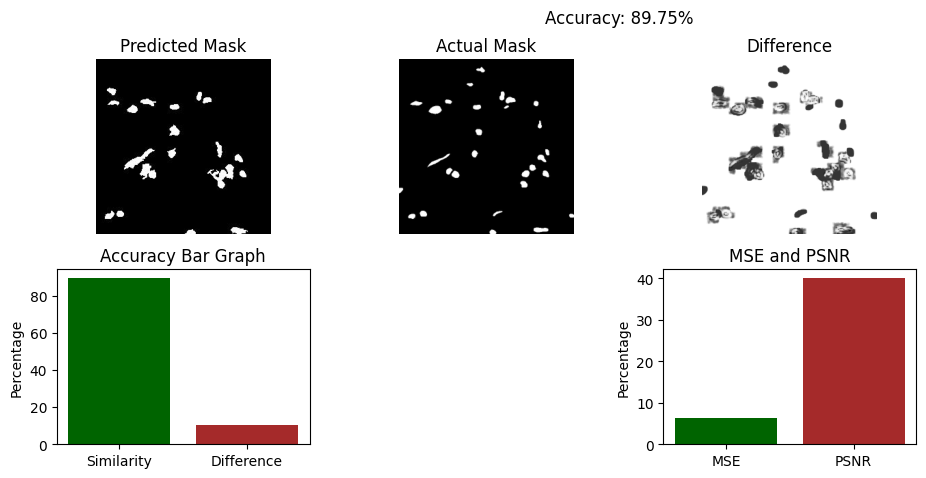

Similarity Percentage: 89.75%
MSE: 6.25
PSNR: 40.17 dB


In [ ]:
import cv2
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt

def compare_images(image1_path, image2_path):
    # Load images
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)

    # Convert to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Resize both images to a common size
    common_size = (500, 500)  # Example common size
    gray1 = cv2.resize(gray1, common_size)
    gray2 = cv2.resize(gray2, common_size)

    # Compute SSIM between two images
    similarity_index, diff = ssim(gray1, gray2, full=True)

    # Compute MSE
    mse = np.mean((gray1 - gray2) ** 2)

    # Compute PSNR
    if mse == 0:
        psnr = 100
    else:
        psnr = 20 * np.log10(255 / np.sqrt(mse))

    # Convert SSIM to percentage
    similarity_percentage = similarity_index * 100
    difference_percentage = 100 - similarity_percentage

    # Plot the images and their difference
    plt.figure(figsize=(15, 5))

    plt.subplot(2, 4, 1)
    plt.title("Predicted Mask")
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(2, 4, 2)
    plt.title("Actual Mask")
    plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(2, 4, 3)
    plt.title("Difference")
    plt.imshow(diff, cmap='gray')
    plt.axis('off')

    # Plot bar graph for accuracy
    plt.subplot(2, 4, 5)
    plt.title("Accuracy Bar Graph")
    plt.bar(['Similarity', 'Difference'], [similarity_percentage, difference_percentage], color=['Darkgreen', 'Brown'])
    plt.ylabel('Percentage')

    # Plot bar graph for accuracy
    plt.subplot(2, 4, 7)
    plt.title("MSE and PSNR")
    plt.bar(['MSE', 'PSNR'], [mse, psnr], color=['Darkgreen', 'Brown'])
    plt.ylabel('Percentage')

    plt.suptitle(f'Accuracy: {similarity_percentage:.2f}%')

    plt.show()

    return similarity_percentage, mse, psnr

# Example usage
image1_path = '/content/segmented_image.jpg'
image2_path = '/content/drive/MyDrive/dataset/masks/0 (9).png'

similarity_percentage, mse, psnr = compare_images(image1_path, image2_path)
print(f'Similarity Percentage: {similarity_percentage:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'PSNR: {psnr:.2f} dB')
